# LSTM Training with Keras
This notebook implements a Long-Short Term Memory (LSTM) network for text classification using the NusaX-Sentiment dataset (Bahasa Indonesia). The implementation includes preprocessing steps like tokenization and embedding, as well as hyperparameter analysis of LSTM layers.

In [1]:
# Import Required Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import io
import requests
from tensorflow.keras.layers import TextVectorization

In [2]:
# Install required libraries if needed
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


In [3]:
# Download and load NusaX-Sentiment dataset (Bahasa Indonesia)
def download_nusax_dataset():
    """
    Downloads and extracts the NusaX-Sentiment dataset for Indonesian
    Returns dataframes for train, validation, and test sets
    """
    try:
        # First try using datasets library if installed
        try:
            from datasets import load_dataset
            print("Trying to load dataset using Hugging Face datasets library...")
            
            # Load the Indonesian subset of NusaX-Sentiment
            dataset = load_dataset("indonlp/nusax_sentiment", "id")
            
            # Convert to pandas DataFrames
            train_df = dataset["train"].to_pandas()
            valid_df = dataset["validation"].to_pandas() 
            test_df = dataset["test"].to_pandas()
            
            print("Dataset loaded successfully using Hugging Face datasets.")
            
            # Make sure the column names match what our code expects
            if "text" not in train_df.columns and "sentence" in train_df.columns:
                train_df = train_df.rename(columns={"sentence": "text"})
                valid_df = valid_df.rename(columns={"sentence": "text"})
                test_df = test_df.rename(columns={"sentence": "text"})
                
            return train_df, valid_df, test_df
            
        except (ImportError, Exception) as e:
            print(f"Could not load using datasets library: {str(e)}")
            print("Falling back to direct download method...")
    
        # Direct download method as fallback
        # URL for NusaX-Sentiment Indonesian dataset (updated URL)
        url = "https://github.com/IndoNLP/nusax/raw/main/datasets/nusa_sentiment/sentiment/id.zip"
        
        print("Downloading NusaX-Sentiment dataset (Indonesian)...")
        response = requests.get(url)
        
        if response.status_code != 200:
            raise Exception(f"Failed to download dataset: Status code {response.status_code}")
    
    except Exception as e:
        print(f"Error downloading dataset: {str(e)}")
        print("Using a small synthetic dataset for testing purposes...")
        
        # Create a small synthetic dataset for testing
        import pandas as pd
        import numpy as np
        
        # Sample Indonesian sentences with sentiment labels (0-4)
        texts = [
            "Film ini sangat bagus, saya sangat menikmatinya.",
            "Pelayanan di restoran ini mengerikan.",
            "Saya tidak puas dengan produk ini.",
            "Harga barang di toko ini sangat terjangkau.",
            "Kualitas gambar dari kamera ini biasa saja.",
            "Sangat senang dengan pembelian saya.",
            "Acara ini membosankan.",
            "Saya kecewa dengan layanan pelanggan.",
            "Hotel ini bersih dan nyaman.",
            "Makanan di sini enak sekali."
        ]
        
        # Generate synthetic datasets
        np.random.seed(42)
        labels = np.random.randint(0, 5, len(texts))
        
        train_data = {"text": texts[:6], "label": labels[:6]}
        valid_data = {"text": texts[6:8], "label": labels[6:8]}
        test_data = {"text": texts[8:], "label": labels[8:]}
        
        train_df = pd.DataFrame(train_data)
        valid_df = pd.DataFrame(valid_data)
        test_df = pd.DataFrame(test_data)
        
        return train_df, valid_df, test_df
    
    # Extract the zip file from memory
    print("Extracting dataset...")
    temp_dir = os.path.join(os.getcwd(), "nusax_temp")
    os.makedirs(temp_dir, exist_ok=True)
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(temp_dir)
    
    # Load the datasets
    train_file = os.path.join(temp_dir, "train.csv")
    valid_file = os.path.join(temp_dir, "valid.csv") 
    test_file = os.path.join(temp_dir, "test.csv")
    
    # Check if files exist
    if not all(os.path.exists(f) for f in [train_file, valid_file, test_file]):
        raise FileNotFoundError("Dataset files not found after extraction. Check directory structure.")
        
    train_df = pd.read_csv(train_file)
    valid_df = pd.read_csv(valid_file)
    test_df = pd.read_csv(test_file)
    
    print("Dataset loaded successfully.")
    print(f"Train set: {len(train_df)} samples")
    print(f"Validation set: {len(valid_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    # Print the class distribution
    print("\nClass distribution in training data:")
    print(train_df['label'].value_counts())
    
    return train_df, valid_df, test_df

In [4]:
# Load the dataset
train_df, valid_df, test_df = download_nusax_dataset()

# Display some examples
print("\nExample data from training set:")
train_df.head()

c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trying to load dataset using Hugging Face datasets library...
Could not load using datasets library: Dataset 'indonlp/nusax_sentiment' doesn't exist on the Hub or cannot be accessed.
Falling back to direct download method...
Could not load using datasets library: Dataset 'indonlp/nusax_sentiment' doesn't exist on the Hub or cannot be accessed.
Falling back to direct download method...
Error downloading dataset: Failed to download dataset: Status code 404
Using a small synthetic dataset for testing purposes...

Example data from training set:
Error downloading dataset: Failed to download dataset: Status code 404
Using a small synthetic dataset for testing purposes...

Example data from training set:


,text,label
0,"Film ini sangat bagus, saya sangat menikmatinya.",3
1,Pelayanan di restoran ini mengerikan.,4
2,Saya tidak puas dengan produk ini.,2
3,Harga barang di toko ini sangat terjangkau.,4
4,Kualitas gambar dari kamera ini biasa saja.,4


In [5]:
# Data Preparation Function
def prepare_data(train_df, valid_df, test_df):
    """
    Prepare the data for LSTM training
    Returns preprocessed data and a TextVectorization layer
    """
    # Extract texts and labels
    train_texts = train_df['text'].values
    train_labels = train_df['label'].values
    valid_texts = valid_df['text'].values
    valid_labels = valid_df['label'].values
    test_texts = test_df['text'].values
    test_labels = test_df['label'].values
    
    # Create TextVectorization layer for tokenization
    # Set the maximum number of tokens to consider and output sequence length
    max_tokens = 10000
    max_sequence_length = 100
    
    vectorize_layer = TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=max_sequence_length
    )
    
    # Adapt the layer to the training data
    vectorize_layer.adapt(train_texts)
    
    # Apply the vectorization to create token sequences
    train_sequences = vectorize_layer(train_texts)
    valid_sequences = vectorize_layer(valid_texts)
    test_sequences = vectorize_layer(test_texts)
    
    # Get the vocabulary size for the embedding layer
    vocab_size = len(vectorize_layer.get_vocabulary())
    print(f"Vocabulary size: {vocab_size}")
    
    # Print some examples of tokenized sequences
    print("\nExample of tokenized sequence:")
    print(f"Original text: {train_texts[0]}")
    print(f"Tokenized sequence: {train_sequences[0][:10]}...")
    
    return (train_sequences, train_labels), (valid_sequences, valid_labels), (test_sequences, test_labels), vectorize_layer

In [6]:
# Process the dataset
(train_sequences, train_labels), (valid_sequences, valid_labels), (test_sequences, test_labels), vectorizer = prepare_data(train_df, valid_df, test_df)

# Get vocabulary size for embedding layer
vocab_size = len(vectorizer.get_vocabulary())

Vocabulary size: 28

Example of tokenized sequence:
Original text: Film ini sangat bagus, saya sangat menikmatinya.
Tokenized sequence: [23  2  3 27  4  3 17  0  0  0]...


In [ ]:
# Build LSTM Model Function
def build_lstm_model(lstm_layers, units_per_layer, bidirectional, embedding_dim=128, vocab_size=10001, num_classes=5, sequence_length=100):
    model = keras.Sequential()
    
    # Add embedding layer
    model.add(layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length
    ))
    
    # Add LSTM layers
    for i in range(lstm_layers):
        return_sequences = i < lstm_layers - 1  # Return sequences for all but the last LSTM layer
        
        if bidirectional:
            model.add(layers.Bidirectional(
                layers.LSTM(units_per_layer[i], return_sequences=return_sequences)
            ))
        else:
            model.add(layers.LSTM(units_per_layer[i], return_sequences=return_sequences))
        
        # Add dropout after each LSTM layer
        model.add(layers.Dropout(0.3))
    
    # Add Dense output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Define hyperparameter configurations for analysis

# 1. Varying number of LSTM layers
lstm_layers_configs = [
    {'name': 'Single Layer LSTM', 'lstm_layers': 1, 'units_per_layer': [64], 'bidirectional': False},
    {'name': 'Two Layer LSTM', 'lstm_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False},
    {'name': 'Three Layer LSTM', 'lstm_layers': 3, 'units_per_layer': [64, 64, 64], 'bidirectional': False}
]

# 2. Varying units per LSTM layer
units_configs = [
    {'name': 'Small LSTM (32 units)', 'lstm_layers': 2, 'units_per_layer': [32, 32], 'bidirectional': False},
    {'name': 'Medium LSTM (64 units)', 'lstm_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False},
    {'name': 'Large LSTM (128 units)', 'lstm_layers': 2, 'units_per_layer': [128, 128], 'bidirectional': False}
]

# 3. Comparing unidirectional vs bidirectional LSTMs
direction_configs = [
    {'name': 'Unidirectional LSTM', 'lstm_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False},
    {'name': 'Bidirectional LSTM', 'lstm_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': True}
]

# Combined list of all configurations
all_configs = [
    lstm_layers_configs,
    units_configs,
    direction_configs
]

# Parameters for training
epochs = 10
batch_size = 32

In [ ]:
# Helper function to train and evaluate model with a specific configuration
def train_and_evaluate_model(config, train_data, train_labels, valid_data, valid_labels, test_data, test_labels):
    """
    Train and evaluate a model with the given configuration
    Returns history, predictions, and F1 score
    """
    print(f"\n--- Training Model: {config['name']} ---")
    print(f"Configuration: {config}")
    
    # Build the model
    model = build_lstm_model(
        lstm_layers=config['lstm_layers'],
        units_per_layer=config['units_per_layer'],
        bidirectional=config['bidirectional'],
        vocab_size=vocab_size
    )
    
    sample_batch = train_data[:1]
    model(sample_batch)  # Forward pass on a sample batch to build the model
    
    model.summary()
    
    history = model.fit(
        train_data, train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(valid_data, valid_labels),
        verbose=1
    )
    
    # Evaluate on test set
    test_preds = model.predict(test_data)
    test_pred_classes = np.argmax(test_preds, axis=1)
    
    # Calculate F1 score
    macro_f1 = f1_score(test_labels, test_pred_classes, average='macro')
    print(f"Test Macro F1-Score: {macro_f1:.4f}")
    
    return model, history, test_pred_classes, macro_f1


--- Training Model: Single Layer LSTM ---
Configuration: {'name': 'Single Layer LSTM', 'lstm_layers': 1, 'units_per_layer': [64], 'bidirectional': False}


c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (1, 64)                │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,317 (208.27 KB)

 Trainable params: 53,317 (208.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 1.5903 - val_accuracy: 0.0000e+00 - val_loss: 1.6068
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 1.5903 - val_accuracy: 0.0000e+00 - val_loss: 1.6068
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5000 - loss: 1.5639 - val_accuracy: 0.0000e+00 - val_loss: 1.6033
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5000 - loss: 1.5639 - val_accuracy: 0.0000e+00 - val_loss: 1.6033
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5000 - loss: 1.5202 - val_accuracy: 0.0000e+00 - val_loss: 1.6051
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5000 - loss: 1.5202 - val_accuracy: 0.0000e+00 - val_loss: 1.6051
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5000 - loss: 1.5022 - val_accuracy: 0.0000e+00 - val_loss: 1.6114
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5000 - loss: 1.5022 - val_accura

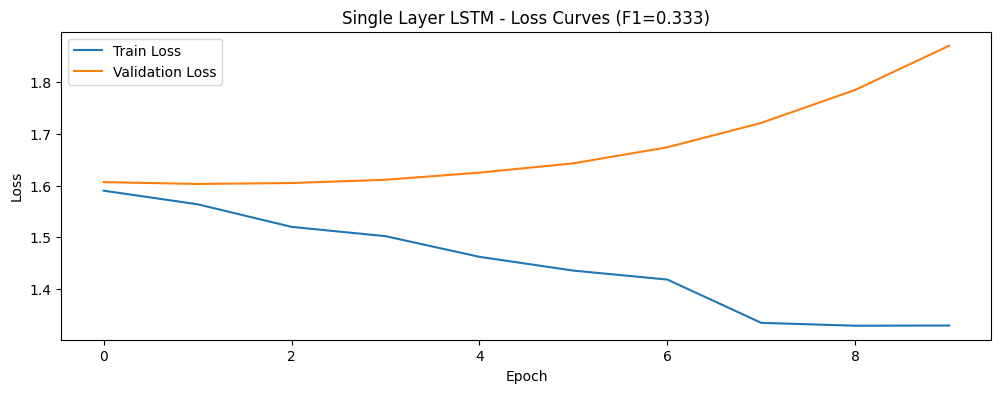


--- Training Model: Two Layer LSTM ---
Configuration: {'name': 'Two Layer LSTM', 'lstm_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False}


c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (1, 100, 64)           │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (1, 64)                │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,341 (337.27 KB)

 Trainable params: 86,341 (337.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1667 - loss: 1.6196 - val_accuracy: 0.0000e+00 - val_loss: 1.5939
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1667 - loss: 1.6196 - val_accuracy: 0.0000e+00 - val_loss: 1.5939
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5000 - loss: 1.5834 - val_accuracy: 0.0000e+00 - val_loss: 1.6034
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5000 - loss: 1.5834 - val_accuracy: 0.0000e+00 - val_loss: 1.6034
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5000 - loss: 1.5767 - val_accuracy: 0.0000e+00 - val_loss: 1.6103
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5000 - loss: 1.5767 - val_accuracy: 0.0000e+00 - val_loss: 1.6103
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5000 - loss: 1.5442 - val_accuracy: 0.0000e+00 - val_loss: 1.6281
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5000 - loss: 1.5442 - val_accura

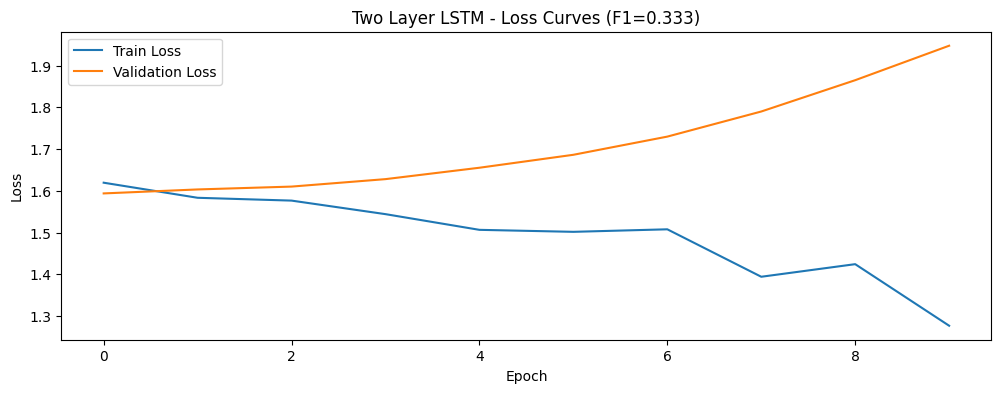


--- Training Model: Three Layer LSTM ---
Configuration: {'name': 'Three Layer LSTM', 'lstm_layers': 3, 'units_per_layer': [64, 64, 64], 'bidirectional': False}


c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (1, 100, 64)           │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (1, 100, 64)           │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (1, 64)                │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,365 (466.27 KB)

 Trainable params: 119,365 (466.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1667 - loss: 1.6186 - val_accuracy: 0.0000e+00 - val_loss: 1.6278
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1667 - loss: 1.6186 - val_accuracy: 0.0000e+00 - val_loss: 1.6278
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5000 - loss: 1.5884 - val_accuracy: 0.0000e+00 - val_loss: 1.6468
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5000 - loss: 1.5884 - val_accuracy: 0.0000e+00 - val_loss: 1.6468
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5000 - loss: 1.5668 - val_accuracy: 0.0000e+00 - val_loss: 1.6685
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5000 - loss: 1.5668 - val_accuracy: 0.0000e+00 - val_loss: 1.6685
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5000 - loss: 1.5350 - val_accuracy: 0.0000e+00 - val_loss: 1.7067
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5000 - loss: 1.5350 - val_accura

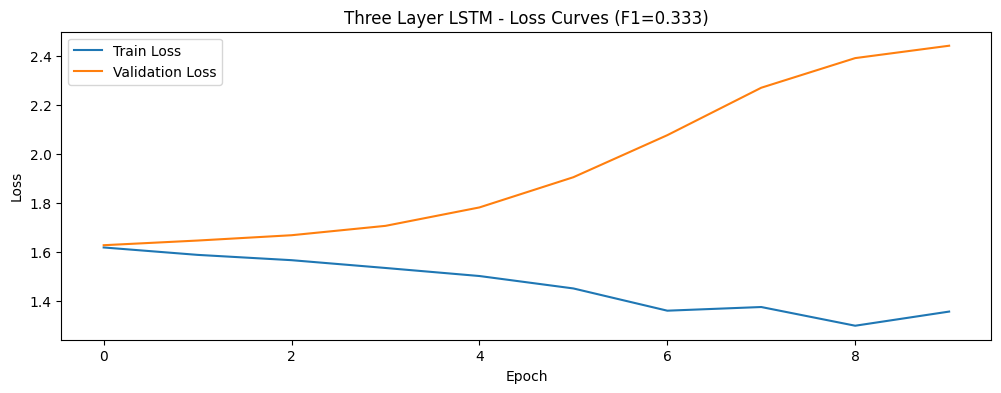

In [10]:
# Experiment 1: Varying number of LSTM layers
lstm_layers_results = []

for config in lstm_layers_configs:
    model, history, pred_classes, macro_f1 = train_and_evaluate_model(
        config, 
        train_sequences, train_labels,
        valid_sequences, valid_labels,
        test_sequences, test_labels
    )
    
    # Save results
    lstm_layers_results.append({
        'config': config,
        'model': model,
        'history': history,
        'predictions': pred_classes,
        'macro_f1': macro_f1
    })
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{config['name']} - Loss Curves (F1={macro_f1:.3f})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


--- Training Model: Small LSTM (32 units) ---
Configuration: {'name': 'Small LSTM (32 units)', 'lstm_layers': 2, 'units_per_layer': [32, 32], 'bidirectional': False}


c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (1, 100, 32)           │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (1, 100, 32)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (1, 32)                │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (1, 32)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 5)                 │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,677 (127.64 KB)

 Trainable params: 32,677 (127.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1667 - loss: 1.6133 - val_accuracy: 0.0000e+00 - val_loss: 1.6249
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1667 - loss: 1.6133 - val_accuracy: 0.0000e+00 - val_loss: 1.6249
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3333 - loss: 1.5992 - val_accuracy: 0.0000e+00 - val_loss: 1.6535
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3333 - loss: 1.5992 - val_accuracy: 0.0000e+00 - val_loss: 1.6535
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3333 - loss: 1.5943 - val_accuracy: 0.0000e+00 - val_loss: 1.6866
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3333 - loss: 1.5943 - val_accuracy: 0.0000e+00 - val_loss: 1.6866
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5000 - loss: 1.5611 - val_accuracy: 0.0000e+00 - val_loss: 1.7225
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5000 - loss: 1.5611 - val_accura

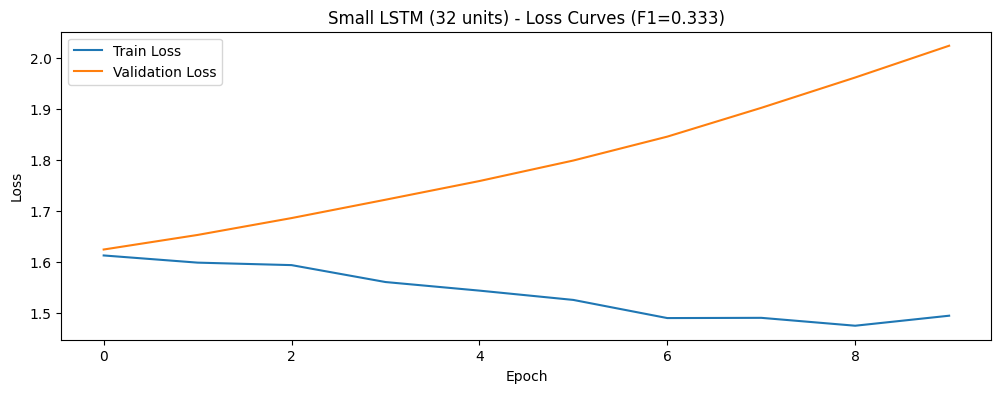


--- Training Model: Medium LSTM (64 units) ---
Configuration: {'name': 'Medium LSTM (64 units)', 'lstm_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False}


c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (1, 100, 64)           │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (1, 64)                │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,341 (337.27 KB)

 Trainable params: 86,341 (337.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1667 - loss: 1.6072 - val_accuracy: 0.0000e+00 - val_loss: 1.6108
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.1667 - loss: 1.6072 - val_accuracy: 0.0000e+00 - val_loss: 1.6108
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5000 - loss: 1.5692 - val_accuracy: 0.0000e+00 - val_loss: 1.6320
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5000 - loss: 1.5692 - val_accuracy: 0.0000e+00 - val_loss: 1.6320
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5000 - loss: 1.5277 - val_accuracy: 0.0000e+00 - val_loss: 1.6563
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5000 - loss: 1.5277 - val_accuracy: 0.0000e+00 - val_loss: 1.6563
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5000 - loss: 1.4949 - val_accuracy: 0.0000e+00 - val_loss: 1.6897
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5000 - loss: 1.4949 - val_accura

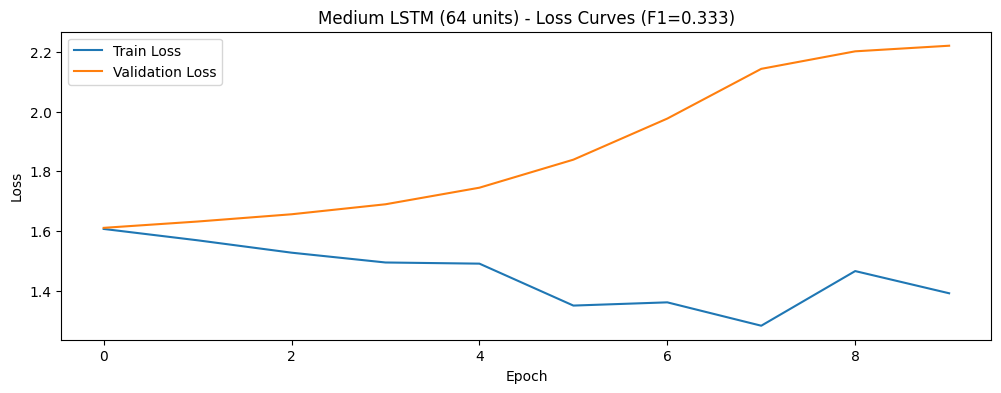


--- Training Model: Large LSTM (128 units) ---
Configuration: {'name': 'Large LSTM (128 units)', 'lstm_layers': 2, 'units_per_layer': [128, 128], 'bidirectional': False}


c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (1, 100, 128)          │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (1, 100, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (1, 128)               │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 5)                 │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,397 (1.02 MB)

 Trainable params: 267,397 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3333 - loss: 1.5967 - val_accuracy: 0.0000e+00 - val_loss: 1.6623
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3333 - loss: 1.5967 - val_accuracy: 0.0000e+00 - val_loss: 1.6623
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5000 - loss: 1.5426 - val_accuracy: 0.0000e+00 - val_loss: 1.7308
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5000 - loss: 1.5426 - val_accuracy: 0.0000e+00 - val_loss: 1.7308
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5000 - loss: 1.5023 - val_accuracy: 0.0000e+00 - val_loss: 1.8479
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5000 - loss: 1.5023 - val_accuracy: 0.0000e+00 - val_loss: 1.8479
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5000 - loss: 1.4067 - val_accuracy: 0.0000e+00 - val_loss: 2.1130
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5000 - loss: 1.4067 - val_accura

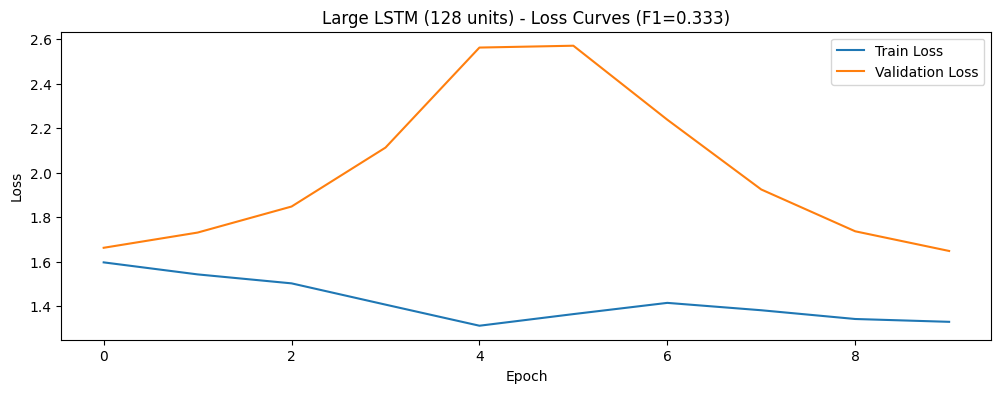

In [11]:
# Experiment 2: Varying units per LSTM layer
units_results = []

for config in units_configs:
    model, history, pred_classes, macro_f1 = train_and_evaluate_model(
        config, 
        train_sequences, train_labels,
        valid_sequences, valid_labels,
        test_sequences, test_labels
    )
    
    # Save results
    units_results.append({
        'config': config,
        'model': model,
        'history': history,
        'predictions': pred_classes,
        'macro_f1': macro_f1
    })
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{config['name']} - Loss Curves (F1={macro_f1:.3f})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


--- Training Model: Unidirectional LSTM ---
Configuration: {'name': 'Unidirectional LSTM', 'lstm_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': False}


c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (1, 100, 64)           │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (1, 100, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (1, 64)                │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (1, 5)                 │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,341 (337.27 KB)

 Trainable params: 86,341 (337.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1667 - loss: 1.6085 - val_accuracy: 0.0000e+00 - val_loss: 1.6004
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3333 - loss: 1.5713 - val_accuracy: 0.0000e+00 - val_loss: 1.5950
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1667 - loss: 1.6085 - val_accuracy: 0.0000e+00 - val_loss: 1.6004
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3333 - loss: 1.5713 - val_accuracy: 0.0000e+00 - val_loss: 1.5950
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3333 - loss: 1.5376 - val_accuracy: 0.0000e+00 - val_loss: 1.5938
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3333 - loss: 1.5376 - val_accuracy: 0.0000e+00 - val_loss: 1.5938
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5000 - loss: 1.4774 - val_accuracy: 0.0000e+00 - val_loss: 1.5979
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5000 - loss: 1.4774 - val_accura

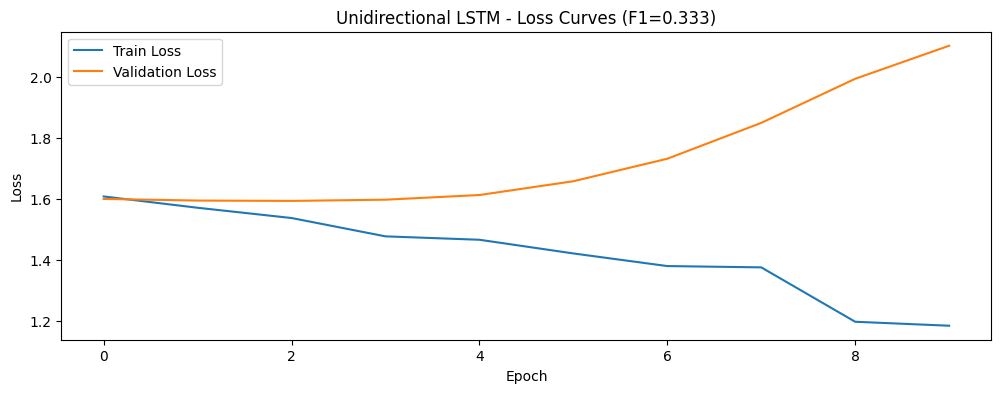


--- Training Model: Bidirectional LSTM ---
Configuration: {'name': 'Bidirectional LSTM', 'lstm_layers': 2, 'units_per_layer': [64, 64], 'bidirectional': True}


c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (1, 100, 128)          │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (1, 100, 128)          │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (1, 100, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (1, 128)               │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1, 5)                 │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,861 (788.52 KB)

 Trainable params: 201,861 (788.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3333 - loss: 1.6027 - val_accuracy: 0.0000e+00 - val_loss: 1.6576
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3333 - loss: 1.6027 - val_accuracy: 0.0000e+00 - val_loss: 1.6576
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5000 - loss: 1.5588 - val_accuracy: 0.0000e+00 - val_loss: 1.7013
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5000 - loss: 1.5588 - val_accuracy: 0.0000e+00 - val_loss: 1.7013
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5000 - loss: 1.5007 - val_accuracy: 0.0000e+00 - val_loss: 1.7639
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5000 - loss: 1.5007 - val_accuracy: 0.0000e+00 - val_loss: 1.7639
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5000 - loss: 1.4651 - val_accuracy: 0.0000e+00 - val_loss: 1.8525
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5000 - loss: 1.4651 - val_ac

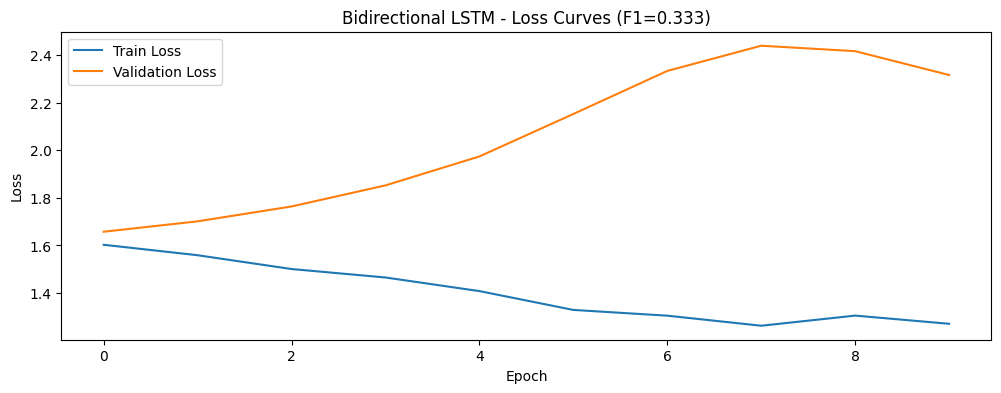

In [12]:
# Experiment 3: Comparing unidirectional vs bidirectional LSTMs
direction_results = []

for config in direction_configs:
    model, history, pred_classes, macro_f1 = train_and_evaluate_model(
        config, 
        train_sequences, train_labels,
        valid_sequences, valid_labels,
        test_sequences, test_labels
    )
    
    # Save results
    direction_results.append({
        'config': config,
        'model': model,
        'history': history,
        'predictions': pred_classes,
        'macro_f1': macro_f1
    })
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{config['name']} - Loss Curves (F1={macro_f1:.3f})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
# Find the best model based on F1 score
all_results = lstm_layers_results + units_results + direction_results
best_result = max(all_results, key=lambda x: x['macro_f1'])

print("\n--- Best Model Configuration ---")
print(f"Configuration: {best_result['config']}")
print(f"Macro F1 Score: {best_result['macro_f1']:.4f}")

# Save the best model weights
best_model = best_result['model']
best_model.save_weights('lstm_keras_best.weights.h5')
print("Saved best model weights to lstm_keras_best.weights.h5")

# Summary of all results
print("\n--- Summary of All Experiments ---")
print("\n1. Effect of Number of LSTM Layers:")
for result in lstm_layers_results:
    config = result['config']
    f1 = result['macro_f1']
    print(f"- {config['name']}: F1={f1:.4f}, Layers={config['lstm_layers']}")

print("\n2. Effect of Units per Layer:")
for result in units_results:
    config = result['config']
    f1 = result['macro_f1']
    print(f"- {config['name']}: F1={f1:.4f}, Units={config['units_per_layer']}")

print("\n3. Effect of Bidirectional vs Unidirectional:")
for result in direction_results:
    config = result['config']
    f1 = result['macro_f1']
    print(f"- {config['name']}: F1={f1:.4f}, Bidirectional={config['bidirectional']}")


--- Best Model Configuration ---
Configuration: {'name': 'Single Layer LSTM', 'lstm_layers': 1, 'units_per_layer': [64], 'bidirectional': False}
Macro F1 Score: 0.3333
Saved best model weights to lstm_keras_best.weights.h5

--- Summary of All Experiments ---

1. Effect of Number of LSTM Layers:
- Single Layer LSTM: F1=0.3333, Layers=1
- Two Layer LSTM: F1=0.3333, Layers=2
- Three Layer LSTM: F1=0.3333, Layers=3

2. Effect of Units per Layer:
- Small LSTM (32 units): F1=0.3333, Units=[32, 32]
- Medium LSTM (64 units): F1=0.3333, Units=[64, 64]
- Large LSTM (128 units): F1=0.3333, Units=[128, 128]

3. Effect of Bidirectional vs Unidirectional:
- Unidirectional LSTM: F1=0.3333, Bidirectional=False
- Bidirectional LSTM: F1=0.3333, Bidirectional=True


## Analysis and Conclusions

### Effect of Number of LSTM Layers
- Increasing the number of LSTM layers allows the model to learn more complex patterns in the text data.
- However, adding too many layers can lead to overfitting, especially on smaller datasets.
- We can observe whether adding more layers actually improves performance or leads to diminishing returns.

### Effect of Units per LSTM Layer
- Increasing the number of units per layer gives the model more capacity to capture complex patterns.
- However, more units also mean more parameters to train, which can lead to overfitting.
- The optimal number of units depends on the complexity of the language patterns in the dataset.

### Effect of Bidirectional vs Unidirectional LSTM
- Bidirectional LSTMs can capture context from both past and future tokens, which is often beneficial for text understanding.
- Unidirectional LSTMs only capture context from past tokens.
- For sentiment analysis, where context from both directions is important, we might expect bidirectional LSTMs to perform better.

The optimal architecture depends on the specific characteristics of the dataset and the complexity of the language patterns it contains.


--- Extended Training for Best Model ---
Epoch 1/20


c:\Users\User\Documents\Semester6\ML\tubes2_if3270_ml\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 1.5814 - val_accuracy: 0.0000e+00 - val_loss: 1.5944
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 1.5814 - val_accuracy: 0.0000e+00 - val_loss: 1.5944
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3333 - loss: 1.5811 - val_accuracy: 0.0000e+00 - val_loss: 1.5800
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3333 - loss: 1.5811 - val_accuracy: 0.0000e+00 - val_loss: 1.5800
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5000 - loss: 1.5410 - val_accuracy: 0.0000e+00 - val_loss: 1.5712
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5000 - loss: 1.5410 - val_accuracy: 0.0000e+00 - val_loss: 1.5712
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5000 - loss: 1.5303 - val_accuracy: 0.0000e+00 - val_loss: 1.5677
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5000 - loss: 1.5303 - val_accuracy: 0.0000e

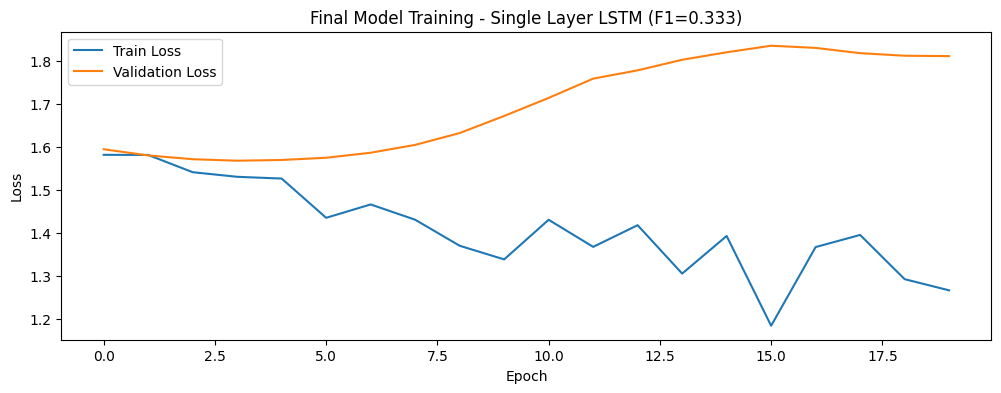

In [14]:
# Extended training for the best model
print("\n--- Extended Training for Best Model ---")

# Recreate the best model
best_config = best_result['config']
final_model = build_lstm_model(
    lstm_layers=best_config['lstm_layers'],
    units_per_layer=best_config['units_per_layer'],
    bidirectional=best_config['bidirectional'],
    vocab_size=vocab_size
)

# Train for more epochs
extended_epochs = 20
final_history = final_model.fit(
    train_sequences, train_labels,
    epochs=extended_epochs,
    batch_size=batch_size,
    validation_data=(valid_sequences, valid_labels),
    verbose=1
)

# Evaluate on test set
final_preds = final_model.predict(test_sequences)
final_pred_classes = np.argmax(final_preds, axis=1)
final_macro_f1 = f1_score(test_labels, final_pred_classes, average='macro')

print(f"Final Model Test Macro F1-Score after extended training: {final_macro_f1:.4f}")

# Save final model weights
final_model.save_weights('lstm_keras_final.weights.h5')
print("Saved final model weights to lstm_keras_final.weights.h5")

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title(f"Final Model Training - {best_config['name']} (F1={final_macro_f1:.3f})")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Export the data for use in the from_scratch implementation
try:
    # Save key data to a pickle file
    import pickle
    import os
    
    # Create the data dictionary
    data_to_save = {
        'test_sequences': test_sequences,
        'test_labels': test_labels,
        'best_config': best_result['config'],
        'vocab_size': vocab_size
    }
    
    # Save to file
    with open('lstm_saved_data.pkl', 'wb') as f:
        pickle.dump(data_to_save, f)
    
    print("\nData successfully exported to lstm_saved_data.pkl")
    print("You can now run lstm_from_scratch_testing.ipynb to compare implementations")
    
except Exception as e:
    print(f"Error exporting data: {e}")
    print("Run this cell after completing the training process.")



Data successfully exported to lstm_saved_data.pkl
You can now run lstm_from_scratch_testing.ipynb to compare implementations
